In [198]:
import pandas as pd
import numpy as np

# Load Data

In [199]:
df = pd.read_csv('../data/Online-retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Overview

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Data Cleaning

In [201]:
df["Country"] = df["Country"].str.replace("Israel", "Palestine")

In [202]:
df = df.dropna(subset=['CustomerID'])

In [203]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

## Missing Value

In [204]:
df.dropna(inplace=True)

## outliers

In [205]:
def remove_outliers_iqr(dataframe, column, lower_quantile=0.25, upper_quantile=0.75):
    q1 = dataframe[column].quantile(lower_quantile)
    q3 = dataframe[column].quantile(upper_quantile)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    return dataframe[(dataframe[column] > lower_bound) & (dataframe[column] < upper_bound)]

In [206]:
df = remove_outliers_iqr(df, "UnitPrice", 0.25, 0.65)

In [207]:
df = remove_outliers_iqr(df, "Quantity", 0.30, 0.70)

## Feature Engineering

In [208]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [209]:
# Compute RFM Features
reference_date = df['InvoiceDate'].max()

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

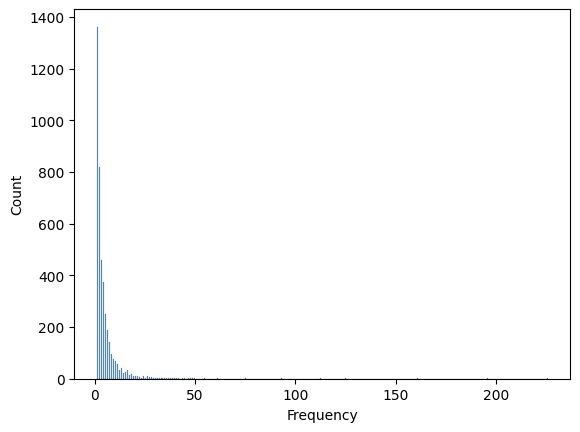

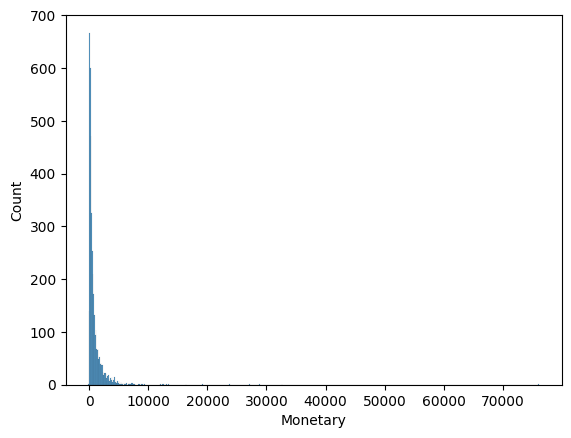

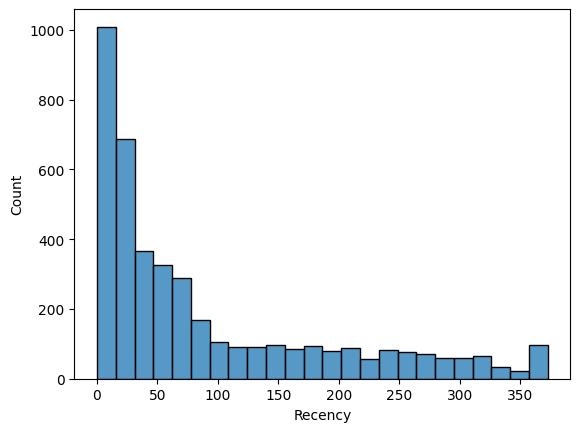

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(rfm['Frequency'])
plt.show()

sns.histplot(rfm['Monetary'])
plt.show()


In [253]:
rfm = rfm[(rfm['Frequency'] > 0) & (rfm['Monetary'] > 0)].copy()

In [254]:
# more suitable for K-means
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])


In [255]:
print(rfm[['Recency_log', 'Frequency_log', 'Monetary_log']].isnull().sum())


Recency_log      0
Frequency_log    0
Monetary_log     0
dtype: int64


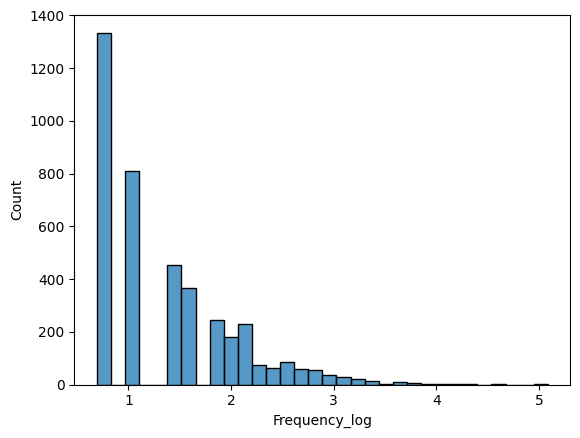

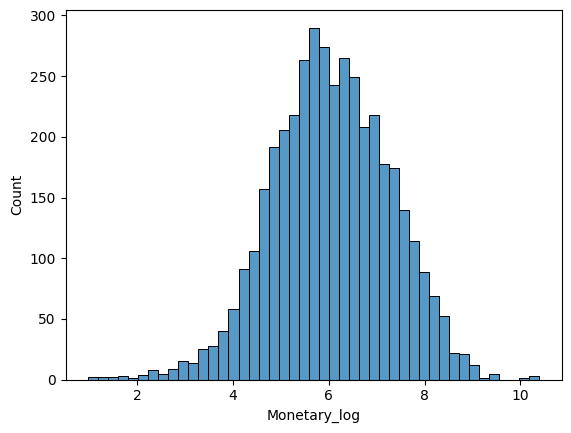

In [256]:
sns.histplot(rfm['Frequency_log'])
plt.show()

sns.histplot(rfm['Monetary_log'])
plt.show()


In [264]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# rfm_scaled = scaler.fit_transform(rfm[
#     ['Recency', 'Frequency_log', 'Monetary_log']
#     ])

# If not using log transformation, replace with:

rfm_scaled = scaler.fit_transform(rfm[
['Recency', 'Frequency', 'Monetary']
])

# Modeling

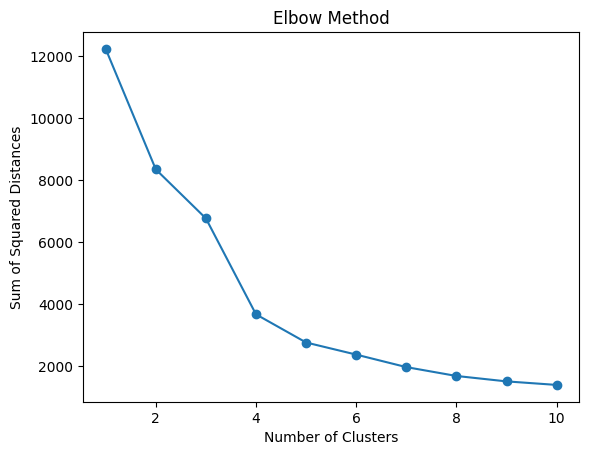

In [265]:
from sklearn.cluster import KMeans

ssd = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    ssd.append(kmeans.inertia_)

plt.plot(range(1, 11), ssd, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt.show()

In [266]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(rfm_scaled)

rfm['Cluster'] = kmeans.labels_

In [267]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',  # or 'Frequency_log' if transformed
    'Monetary': 'mean',   # or 'Monetary_log' if transformed
    'CustomerID': 'count' # Number of customers per cluster
}).reset_index()

print(cluster_summary)

   Cluster     Recency  Frequency      Monetary  CustomerID
0        0   47.967687   2.741497    504.353288        2352
1        1   24.020635   9.625397   2248.483571         630
2        2    3.500000  78.000000  28092.945000           4
3        3  248.447130   1.649547    265.260656         993
4        4   12.122449  26.938776   5636.519388          98


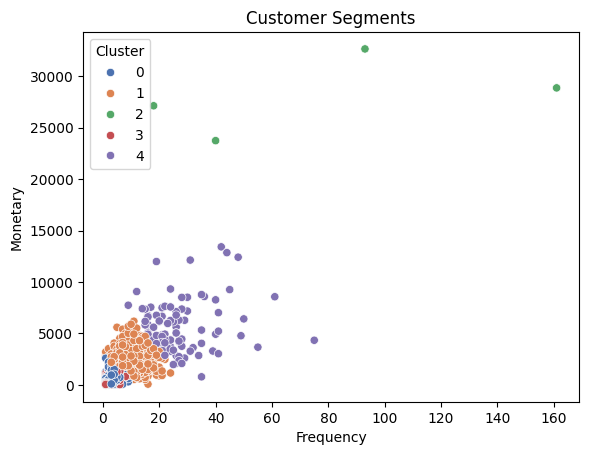

In [268]:
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='deep')
plt.title('Customer Segments')
plt.show()

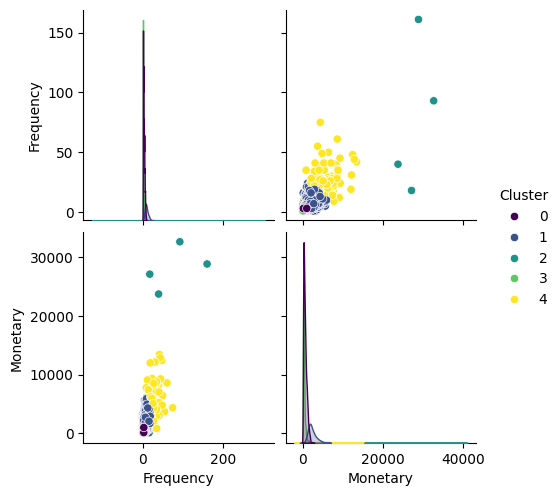

In [269]:
sns.pairplot(data=rfm, vars=['Frequency', 'Monetary'], hue='Cluster', palette='viridis')
plt.show()

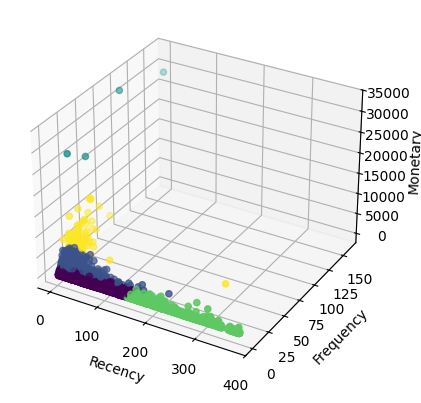

In [270]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster'])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()